Considering the column_diagnosis.arff dataset available at the course webpage’s homework tab.
Using sklearn, apply a 10-fold stratified cross-validation with shuffling (random_state=0) for the
assessment of predictive models along this section.

In [2]:
import pandas as pd
from scipy.io.arff import loadarff
import sklearn

data = loadarff('data/column_diagnosis.arff')
df = pd.DataFrame(data[0])
df['class'] = df['class'].str.decode('utf-8')

X, y = df.drop('class', axis=1), df['class']

df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


1) Compare the performance of 𝑘NN with 𝑘 = 5 and naïve Bayes with Gaussian assumption
(consider all remaining parameters for each classifier as sklearn’s default):

In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

classifiers = [
    ("Gaussian Naive Bayes", GaussianNB()),
    ("kNN", KNeighborsClassifier(n_neighbors=5))
]

a. Plot two boxplots with the folds accuracies for each classifier.

In [4]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
fold_accs = [(cls[0], cross_val_score(cls[1], X, y, cv=folds, scoring='accuracy')) for cls in classifiers]
print(fold_accs)

[('Gaussian Naive Bayes', array([0.83870968, 0.87096774, 0.83870968, 0.87096774, 0.77419355,
       0.83870968, 0.90322581, 0.80645161, 0.77419355, 0.70967742])), ('kNN', array([0.93548387, 0.80645161, 0.87096774, 0.93548387, 0.74193548,
       0.87096774, 0.83870968, 0.83870968, 0.77419355, 0.77419355]))]


/home/daniel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/daniel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/daniel/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Classifier', ylabel='Accuracy'>

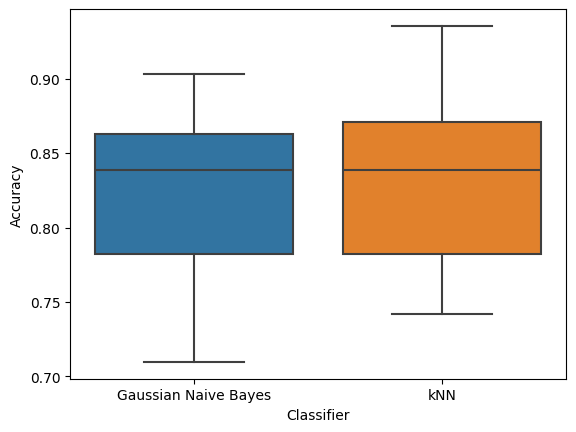

In [5]:
import seaborn as sns

fold_accs_join = []
for cls in fold_accs:
    fold_accs_join.extend(list(zip([cls[0] for i in range(10)], cls[1])))

fold_accs_df = pd.DataFrame(fold_accs_join, columns=['Classifier', 'Accuracy'])

sns.boxplot(x='Classifier', y='Accuracy', data=fold_accs_df)

b. Using scipy, test the hypothesis “𝑘NN is statistically superior to naïve Bayes regarding
accuracy”, asserting whether is true.

In [6]:
from scipy import stats

res = stats.ttest_rel(fold_accs[1][1], fold_accs[0][1], alternative='greater')
print('kNN > NB, pvalue=', res.pvalue)

kNN > NB, pvalue= 0.19042809062064092


Visto que o valor-p é aproximadamente 0.19, não podemos rejeitar a hipótese nula para os valores de significância usuais (geralmente igual ou inferior a 0.05), a favor da hipótese "kNN is statistically superior to naïve Bayes regarding accuracy".

2) Consider two 𝑘NN predictors with 𝑘=1 and 𝑘=5 (uniform weights, Euclidean distance, all remaining parameters as default). Plot the differences between the two cumulative confusion matrices of the predictors. Comment.

kNN(N=1) cumulative confusion matrix:
                    Predicted Normal  Predicted Hernia  \
Normal                           80                14   
Hernia                           23                37   
Spondylolisthesis                 7                 1   

                   Predicted Spondylolisthesis  
Normal                                       6  
Hernia                                       0  
Spondylolisthesis                          142  
kNN(N=5) cumulative confusion matrix:
                    Predicted Normal  Predicted Hernia  \
Normal                           78                19   
Hernia                           21                39   
Spondylolisthesis                 6                 1   

                   Predicted Spondylolisthesis  
Normal                                       3  
Hernia                                       0  
Spondylolisthesis                          143  


<Axes: >

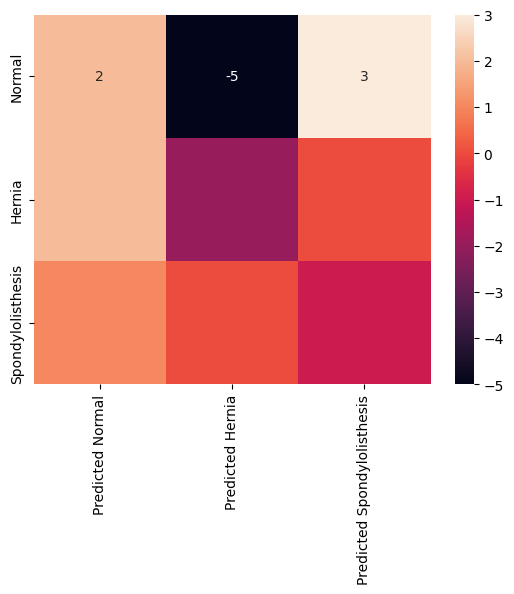

In [30]:
from sklearn import metrics
import numpy as np

knn_1= KNeighborsClassifier(n_neighbors=1)
knn_5= KNeighborsClassifier(n_neighbors=5)

confusion_matrix_knn1 = np.array([[0,0,0], [0,0,0], [0,0,0]])
confusion_matrix_knn5 = np.array([[0,0,0], [0,0,0], [0,0,0]])

for train_k, test_k in folds.split(X, y):
    X_train, X_test = X.iloc[train_k], X.iloc[test_k]
    y_train, y_test = y.iloc[train_k], y.iloc[test_k]

    knn_1.fit(X_train, y_train)
    knn_5.fit(X_train, y_train)

    y_knn1_pred = knn_1.predict(X_test)
    y_knn5_pred = knn_5.predict(X_test)

    confusion_matrix_knn1= confusion_matrix_knn1 + np.array(metrics.confusion_matrix(y_true=y_test, y_pred=y_knn1_pred, labels=['Normal', 'Hernia', 'Spondylolisthesis']))
    confusion_matrix_knn5= confusion_matrix_knn5 + np.array(metrics.confusion_matrix(y_true=y_test, y_pred=y_knn5_pred, labels=['Normal', 'Hernia', 'Spondylolisthesis']))

knn1_df = pd.DataFrame(confusion_matrix_knn1, index = ['Normal', 'Hernia', 'Spondylolisthesis'], columns = ['Predicted Normal', 'Predicted Hernia', 'Predicted Spondylolisthesis'])
knn5_df = pd.DataFrame(confusion_matrix_knn5, index = ['Normal', 'Hernia', 'Spondylolisthesis'], columns = ['Predicted Normal', 'Predicted Hernia', 'Predicted Spondylolisthesis'])

print("kNN(N=1) cumulative confusion matrix:\n", knn1_df)
print("kNN(N=5) cumulative confusion matrix:\n", knn5_df)

sns.heatmap(knn1_df-knn5_df, annot=True, fmt='g')

